In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import math
import numpy
import copy

In [2]:
def gnp_random_graph(n, p, seed=None, directed=False):
    """Returns a $G_{n,p}$ random graph, also known as an Erdős-Rényi graph
    or a binomial graph.

    The $G_{n,p}$ model chooses each of the possible edges with probability $p$.

    Parameters
    ----------
    n : int
        The number of nodes.
    p : float
        Probability for edge creation.
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    directed : bool, optional (default=False)
        If True, this function returns a directed graph.

    See Also
    --------
    fast_gnp_random_graph

    Notes
    -----
    This algorithm [2]_ runs in $O(n^2)$ time.  For sparse graphs (that is, for
    small values of $p$), :func:`fast_gnp_random_graph` is a faster algorithm.

    :func:`binomial_graph` and :func:`erdos_renyi_graph` are
    aliases for :func:`gnp_random_graph`.

    >>> nx.binomial_graph is nx.gnp_random_graph
    True
    >>> nx.erdos_renyi_graph is nx.gnp_random_graph
    True

    References
    ----------
    .. [1] P. Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).
    .. [2] E. N. Gilbert, Random Graphs, Ann. Math. Stat., 30, 1141 (1959).
    """
    if directed:
        edges = itertools.permutations(range(n), 2)
        G = nx.DiGraph()
    else:
        edges = itertools.combinations(range(n), 2)
        G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return complete_graph(n, create_using=G)

    for e in edges:
        if seed.random() < p:
            G.add_edge(*e)
    return G

In [3]:
def averageInDegree(G):
    # sum of the degrees of all its nodes divided by the number of nodes in the graph
    degreeSum = 0
    for node in G.nodes: 
        degreeSum += (G.in_degree[node])
    
    # divide by number of nodes
    return degreeSum/len(G.nodes)
    
def UserActivity(G,node_num):
    return (G.in_degree[node_num]*random.random())/(len(G.nodes))

In [4]:
def sigmoid(x):
    return ((2)/(1+math.exp(-x)))-1


In [5]:
# Compute f_u for all nodes in G 
def compute_tweet_prob(G, TS, UA, scale_factor):
    scale_factor = scale_factor
    w_1 = 0.1
    w_2 = 1-w_1
    
    # compute f_u 
    f = (w_1*TS + w_2*UA)*scale_factor
        
    return f
    

In [6]:
def isMentioned(G,node1,node2):
    isMentioned = 0
    
    if node2 in list(G.neighbors(node1)) and node2 in list(G.predecessors(node1)):
        isMentioned = 1
        
    # add random factor 
    return isMentioned*random.random()

In [7]:
def compute_retweet_prob(G,node1,node2,scale_factor,TS,UA):
    #node1 tweeter/retweeter, node2 follower 
    scale_factor = scale_factor
    # Compute # common following
    # A successor of n is a node m such that there exists a directed edge from n to m. Same as neighbors()
    node1_following = set(G.neighbors(node1))
    node2_following = set(G.neighbors(node2))
    
    
    num_common_following = len(node1_following.intersection(node2_following))
    #print('# Common Following: ', num_common_following)
    # Compute # common followers
    # A predecessor of n is a node m such that there exists a directed edge from m to n.


    node1_followers = set(G.predecessors(node1))
    node2_followers = set(G.predecessors(node2))
    
    num_common_followers = len(node1_followers.intersection(node2_followers))
    #print('# Common Followers: ', num_common_followers)

    # Compute Similarity Score 
    w_following = 0.5
    w_followers = 1-w_following 
    
    SS = w_following*num_common_following + w_followers*num_common_followers
    
    # Compute IsMentioned
    IM = isMentioned(G,node1,node2)
    
    # Compute r_u 
    w_SS = 0.4
    w_TS = 0.1
    w_UA = 0.25
    w_IM = 0.25
    
    r_u = scale_factor*(w_SS*SS + w_TS*TS + w_UA*UA + w_IM*IM)
    
    return r_u

In [8]:
def total_degree_sum(p, num_nodes):
    return p*(num_nodes**2)

In [9]:
import numpy as np 
# Create degree distribution with higher standard deviation
def createRandomDist(numNodes, average, totalDegSum):
    degrees = []
    out_degrees = []
    
    in_degrees = np.random.dirichlet(np.ones(numNodes-1),size=1)[0]
    out_degrees = np.random.dirichlet(np.ones(numNodes-1),size=1)[0]
    
    in_degrees_final = [int(d*totalDegSum) for d in in_degrees]
    out_degrees_final = [int(d*totalDegSum) for d in out_degrees]
    
    # create last value 
    in_deg_sum = sum(in_degrees_final)
    out_deg_sum = sum(out_degrees_final)
    
    diff = in_deg_sum - out_deg_sum 
    
    if diff<0:  # outdeg>indeg
        out_degrees_final.append(0)
        in_degrees_final.append((-1)*diff)
    elif diff>0: # indeg>outeg
        out_degrees_final.append(diff)
        in_degrees_final.append(0)
    else:
        rannum = random.randint(0,300)
        out_degrees_final.append(rannum)
        in_degrees_final.append(rannum)
    
    return in_degrees_final, out_degrees_final


In [187]:
def mff(G, f, r, f_0, r_0):
    S = set()
    N = set()
    fire = [] 
    
    num_spreaders = []
    num_nonspreaders = []
    num_trees = []
    iterations = 0
    status = {}
    checkpoint_frequency = 4
    num_checkpoints = len(G.nodes)/checkpoint_frequency
    
    # 4 checkpoints
    N_checkpoints = []
    
    S_checkpoints = [] 
    
    
    # Initialize statuses of nodes
    for node in G.nodes(): 
        if f[node] >= f_0: 
            #print('Node caught on fire: ', node)
            status[node] = 1
            fire.append(node)
            S.add(node)
        else: 
            status[node] = 0
    
    # Status Guide
        # 1 : fire
        # 0 : tree
        # -1 : burnt

    # Update node statuses 
    while (len(fire)!=0):
        # print('# nodes still on fire: ', len(fire))
        node = fire.pop()
        
        # Check neighbros of node on fire
        for neighbor in G.predecessors(node):
            if status[neighbor] == 0 or status[neighbor] == -1: 
                if r[(node,neighbor)]>= r_0:
                    status[neighbor] = 1
                    fire.append(neighbor)
                    S.add(neighbor)
                    if neighbor in N: 
                        N.remove(neighbor)
                    # change something to fire --> change needToContinue = 1 
                else: 
                    status[neighbor] = -1
                    N.add(neighbor)
        
            num_spreaders.append(len(S))
            num_nonspreaders.append(len(N))
            num_trees.append(len(G.nodes)-(len(S)+len(N)))
            
            if (iterations%num_checkpoints==0):
                N_copy = N.copy()
                S_copy = S.copy()

                N_checkpoints.append(N_copy)
                S_checkpoints.append(S_copy)
                
            iterations= iterations + 1

                
        # query length of S, see if length changed in order to see if nay more nodes caught on fire     
        # line before while loop- needToContinue
        # while needToContinue:
        # needToContninue = 0 
        # could also just keep a nodesVisited, or list of newly fired nodes 
        # LOGIC: every time a node catches on fire, you need to check all of its neighbors later 
    # add one last checkpoint
    N_copy = N.copy()
    S_copy = S.copy()

    N_checkpoints.append(N_copy)
    S_checkpoints.append(S_copy)
    
    return S,N, num_spreaders, num_nonspreaders, num_trees, iterations, N_checkpoints, S_checkpoints
                

# Run 1

In [11]:
# Graph 

numNodes = 1000
p = 0.10
averageDeg = numNodes*p
totalDegSum = total_degree_sum(p,numNodes)

degree = createRandomDist(numNodes, averageDeg,totalDegSum)
in_degrees = degree[0]
#print(type(in_degrees))
out_degrees = degree[1]
#print("\n IN DEGREES \n")
#print((in_degrees))
#print("\n OUT DEGREES \n")
#print((out_degrees))

In [12]:
#G1 = gnp_random_graph(n=1000, p=0.15, seed=numpy.random, directed=True)
G1 = nx.directed_configuration_model(in_degree_sequence = in_degrees,out_degree_sequence = out_degrees)

In [13]:
# Compute all user activities and topic significance 
UA = {}
for node in G1.nodes: 
    UA[node] = UserActivity(G1,node)
    
TS = 1

In [14]:
#### Compute tweet probs 
f_u_init = {}
f_u_sigmoid_init = {}
scale_factor = 3
for node in G1.nodes: 
    # compute f_u 
    f =  compute_tweet_prob(G1,TS,UA[node],scale_factor)
    f_u_init[node]=f
    f_u_sigmoid_init[node] = sigmoid(f)

print(sorted(f_u_sigmoid_init.values()))

[0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14888503362331806, 0.14891546658374866, 0.14896751781087714, 0.14900819692887612, 0.14902272666621097, 0.1490367128246961, 0.14904487681492173, 0.14908133811879498, 0.14910778454755347, 0.14910964348399602, 0.14913024607847536, 0.149131831878905, 0.14914164974192867, 0.14916423186210603, 0.1491787704937011, 0.14919598528504552, 0.14924288007900577, 0.14926938329271278, 0.1493256878339002, 0.14937342995512348, 0.14939216014318268, 0.14942628927320767, 0.14947127445885977, 0.14951468312475402, 0.14952678976342804, 0.14955760375845162, 0.1495863768677559, 0.14966240615908433, 0.14969413163223666, 0.14975355806053003, 0.14975634367412294, 0.1497628390852359

In [15]:
#### Computing retweet prob
r_u_init = {}
r_u_sigmoid_init = {}
scale_factor = 1
for node in G1.nodes: 
    # loop through followers
    for follower in G1.predecessors(node):
        r = compute_retweet_prob(G1,node,follower,scale_factor,TS,UA[node])
        r_u_init[(node,follower)] = r
        r_u_sigmoid_init[(node,follower)] = sigmoid(r)

print(sorted(r_u_sigmoid_init.values()))

[0.04996616611832638, 0.04998612115439194, 0.05004231985461627, 0.050057942139552614, 0.050122084571471825, 0.05017764841217276, 0.05017764841217276, 0.0501798309357937, 0.05026633280588477, 0.05026633280588477, 0.050274585150654305, 0.0502934329092426, 0.0502934329092426, 0.050362545556021265, 0.050362545556021265, 0.05039013737773712, 0.05039013737773712, 0.050553562842517774, 0.050565698782794266, 0.050565698782794266, 0.050569644650448886, 0.050618499065318456, 0.050641915756461486, 0.050641915756461486, 0.050641915756461486, 0.050641915756461486, 0.050641915756461486, 0.05081680441581771, 0.050848045005649434, 0.050848045005649434, 0.050848045005649434, 0.05086454829827147, 0.0508959621523557, 0.0508959621523557, 0.0508959621523557, 0.0508959621523557, 0.0508959621523557, 0.05091480426171735, 0.050991815132726215, 0.050991815132726215, 0.050991815132726215, 0.05120913003363947, 0.0512877966683174, 0.0512877966683174, 0.0512877966683174, 0.0512877966683174, 0.0512877966683174, 0.05

In [16]:
def scale_retweet_probs(scale_factor,r_u_init,r_u_sigmoid_init):
    # SCALE RETWEET PROB
#     r_u_copy = copy.deepcopy(r_u_init)
    r_u_scaled = {}
    r_u_sigmoid_scaled = {} 
    
    for node_pair in r_u_init:
        r = scale_factor*r_u_init[node_pair]
        r_u_scaled[node_pair] = r
        r_u_sigmoid_scaled[node_pair] = sigmoid(r)
        
    return r_u_scaled, r_u_sigmoid_scaled

In [17]:
# 0-.25 with iteration of 0.01
scale_factors = list(np.arange(0, 0.25, 0.01))
print((scale_factors))

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24]


In [18]:
p_spreaders = []
p_nonspreaders = []
trees = []

for sf in scale_factors: 
    # regenerate retweet probs
    r_u_scaled, r_u_sigmoid_scaled = scale_retweet_probs(sf, r_u_init, r_u_sigmoid_init)
    
    # regenerate tweet probs
    #f_u, f_u_sigmoid = scale_tweet_probs(1,f_u,f_u_sigmoid)

    # RUN 
    r_0 = 0.5
    f_0 = 0.5
    lists = mff(G1,f_u_sigmoid_init,r_u_sigmoid_scaled,f_0,r_0)
    S = lists[0]
    N = lists[1]
    num_S = lists[2]
    num_N = lists[3]
    num_T = lists[4]
    
    print(num_S)

    N_checkpoints = lists[6]
    S_checkpoints = lists[7]

    iterations = lists[5]
    p_s = (num_S[-1])/(numNodes)
    p_ns = (num_N[-1])/(numNodes)
    p_spreaders.append(p_s)
    p_nonspreaders.append(p_ns)
    trees.append(1-(p_s+p_ns))


[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,

[12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 26, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30,

[12, 12, 12, 12, 12, 12, 13, 13, 14, 15, 15, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 20, 20, 20, 20, 20, 20, 21, 22, 22, 22, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 37, 37, 38, 38, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 41, 41, 42, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 56, 56, 56, 56, 56, 56, 57,

[12, 12, 12, 12, 12, 12, 13, 13, 14, 15, 15, 16, 17, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 23, 23, 23, 23, 23, 23, 24, 25, 25, 25, 26, 27, 27, 27, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 38, 39, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 42, 43, 43, 44, 44, 45, 45, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 49, 50, 50, 50, 50, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 55, 55, 55, 55, 56, 56, 57, 58, 59, 59, 59, 59, 59, 59, 59, 59, 60, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 67,

[12, 13, 13, 13, 13, 13, 14, 14, 15, 16, 16, 17, 18, 19, 20, 20, 20, 20, 20, 20, 21, 21, 22, 22, 22, 23, 23, 24, 24, 25, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 29, 29, 29, 30, 31, 31, 31, 31, 31, 31, 32, 33, 33, 33, 34, 35, 35, 35, 36, 36, 37, 37, 37, 37, 37, 37, 37, 38, 38, 39, 40, 40, 40, 41, 41, 41, 41, 41, 42, 42, 42, 43, 43, 44, 44, 45, 45, 45, 45, 46, 46, 47, 47, 47, 47, 47, 47, 47, 48, 49, 50, 50, 51, 51, 52, 53, 54, 55, 55, 55, 55, 55, 55, 55, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 59, 60, 60, 60, 60, 61, 62, 62, 62, 62, 62, 62, 63, 63, 63, 64, 64, 65, 66, 67, 68, 68, 69, 69, 70, 70, 70, 70, 70, 71, 71, 72, 72, 72, 72, 72, 72, 73, 73, 74, 75, 75, 75, 75, 76, 76, 77, 77, 77, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 80, 80, 80, 81, 81, 81, 81, 81, 81, 82, 83, 83, 84, 84, 84, 84, 85, 85, 86, 87, 88, 88, 88, 88, 88, 88, 89, 90, 91, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 99, 100, 10

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
print(p_spreaders)
print(p_nonspreaders)

[0.012, 0.012, 0.012, 0.027, 0.123, 0.237, 0.349, 0.447, 0.52, 0.569, 0.628, 0.669, 0.704, 0.743, 0.776, 0.8, 0.82, 0.843, 0.858, 0.869, 0.882, 0.891, 0.897, 0.901, 0.904]
[0.867, 0.867, 0.867, 0.91, 0.854, 0.743, 0.635, 0.538, 0.465, 0.417, 0.359, 0.319, 0.284, 0.245, 0.213, 0.189, 0.17, 0.147, 0.132, 0.121, 0.108, 0.099, 0.093, 0.089, 0.086]


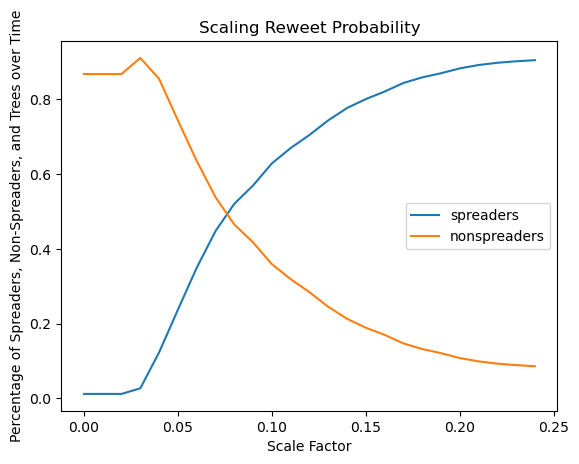

In [20]:
plt.plot(scale_factors,p_spreaders, label="spreaders")
plt.plot(scale_factors,p_nonspreaders, label="nonspreaders")
# plt.plot(scale_factors,trees, label="trees")

plt.xlabel('Title')
plt.ylabel('Percentage of Spreaders, Non-Spreaders, and Trees over Time')
plt.xlabel('Scale Factor')
plt.title('Scaling Reweet Probability')
plt.legend()
plt.show()

In [21]:
def scale_tweet_probs(scale_factor,f_u_init, f_u_sigmoid_init): 
    #f_u_copy = copy.deepcopy(f_u_init)
    f_u_scaled = {}
    f_u_sigmoid_scaled = {}
    
    for node in f_u_init: 
        # compute f_u 
        f = f_u_init[node]*scale_factor 
        f_u_scaled[node]=f
        f_u_sigmoid_scaled[node] = sigmoid(f)
        
    return f_u_scaled, f_u_sigmoid_scaled

In [22]:
#### Compute tweet probs 
f_u_init_2 = {}
f_u_sigmoid_init_2 = {}
scale_factor = 1
for node in G1.nodes: 
    # compute f_u 
    f =  compute_tweet_prob(G1,TS,UA[node],scale_factor)
    f_u_init_2[node]=f
    f_u_sigmoid_init_2[node] = sigmoid(f)

print(sorted(f_u_sigmoid_init_2.values()))

[0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.049958374957880025, 0.0499687233922701, 0.04998642310702439, 0.05000025597626956, 0.050005196827211496, 0.0500099528520086, 0.05001272904365717, 0.05002512790451963, 0.05003412123029016, 0.05003475337935104, 0.05004175950934964, 0.05004229877916666, 0.05004563746244384, 0.05005331681972924, 0.05005826090412535, 0.05006411508283093, 0.05008006258310149, 0.05008907561370801, 0.050108223489777615, 0.05012445971341428, 0.050130829565802726, 0.05014243644766103, 0.05015773549988922, 0.050172498569289736, 0.05017661600738399, 0.05018709583255365, 0.05019688163267766, 0.050222739736441424, 0.05023352995400643, 0.050253741852399614, 0.0502546892

In [23]:
# 0-.25 with iteration of 0.01
scale_factors_2 = list(np.arange(2.5, 7.5, 0.1))
print((scale_factors_2))

[2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0000000000000004, 3.1000000000000005, 3.2000000000000006, 3.3000000000000007, 3.400000000000001, 3.500000000000001, 3.600000000000001, 3.700000000000001, 3.800000000000001, 3.9000000000000012, 4.000000000000002, 4.100000000000001, 4.200000000000001, 4.300000000000002, 4.400000000000002, 4.500000000000002, 4.600000000000001, 4.700000000000002, 4.8000000000000025, 4.900000000000002, 5.000000000000002, 5.100000000000002, 5.200000000000003, 5.3000000000000025, 5.400000000000002, 5.500000000000003, 5.600000000000003, 5.700000000000003, 5.8000000000000025, 5.900000000000003, 6.0000000000000036, 6.100000000000003, 6.200000000000003, 6.300000000000003, 6.400000000000004, 6.5000000000000036, 6.600000000000003, 6.700000000000004, 6.800000000000004, 6.900000000000004, 7.0000000000000036, 7.100000000000004, 7.200000000000005, 7.300000000000004, 7.400000000000004]


In [24]:
p_spreaders2 = []
p_nonspreaders2 = []
trees2 = []

r_u_scaled_static, r_u_sigmoid_scaled_static = scale_retweet_probs(0.07, r_u_init, r_u_sigmoid_init)

#for r_print in r_u_sigmoid_scaled_static.values(): 
 #   print(r_print)

for sf in scale_factors_2: 
    # regenerate retweet probs
    #r_u_scaled, r_u_sigmoid_scaled = scale_retweet_probs(sf, r_u_init, r_u_sigmoid_init)
    
    # regenerate tweet probs
    f_u_scaled, f_u_sigmoid_scaled = scale_tweet_probs(sf,f_u_init_2,f_u_sigmoid_init_2)
    print('F_U_SIGMOID: ', f_u_sigmoid_scaled)
    
    # RUN 
    r_0 = 0.5
    f_0 = 0.5
    lists = mff(G1,f_u_sigmoid_scaled,r_u_sigmoid_scaled_static,f_0,r_0)
    S = lists[0]
    N = lists[1]
    num_S = lists[2]
    num_N = lists[3]
    num_T = lists[4]
    
#     print(num_S)

    N_checkpoints = lists[6]
    S_checkpoints = lists[7]

    iterations = lists[5]
    p_s = (num_S[-1])/(numNodes)
    p_ns = (num_N[-1])/(numNodes)
    p_spreaders2.append(p_s)
    p_nonspreaders2.append(p_ns)
    trees2.append(1-(p_s+p_ns))


F_U_SIGMOID:  {0: 0.12455874860456584, 1: 0.13051266545284923, 2: 0.20894533809807014, 3: 0.18845984167961483, 4: 0.1655048107674375, 5: 0.1271890074273514, 6: 0.2336345588530251, 7: 0.12897566151211248, 8: 0.12538332807021235, 9: 0.3679545667187534, 10: 0.1729843053006841, 11: 0.12437853645717789, 12: 0.1307557910138053, 13: 0.1260200495854722, 14: 0.12456007919418521, 15: 0.20577497866849348, 16: 0.12446853328639507, 17: 0.21207214470071767, 18: 0.18574922497379132, 19: 0.13688677855449316, 20: 0.148742747783825, 21: 0.3708128009853504, 22: 0.13839654484629227, 23: 0.15378074184433554, 24: 0.20470129801853454, 25: 0.14344374881413113, 26: 0.13921459766878463, 27: 0.37006997512922224, 28: 0.15438038550299837, 29: 0.12435300177159614, 30: 0.12630034711131244, 31: 0.12435300177159614, 32: 0.12787978973338365, 33: 0.12670078824037634, 34: 0.30998004799583945, 35: 0.13197126813854987, 36: 0.13186629504052583, 37: 0.12862716041534394, 38: 0.18540465709545928, 39: 0.16245317470804377, 40: 0

F_U_SIGMOID:  {0: 0.13440744179972075, 1: 0.14082020138103135, 2: 0.2251112631711667, 3: 0.2031337272765179, 4: 0.17847261686284566, 5: 0.13724060499660085, 6: 0.2515556642588117, 7: 0.1391649045050256, 8: 0.13529566514905578, 9: 0.3943491895607172, 10: 0.18651171305402348, 11: 0.13421331616914656, 12: 0.14108202849886253, 13: 0.13598150992059077, 14: 0.13440887511357769, 15: 0.22171201463145485, 16: 0.13431026148849523, 17: 0.2284630602355422, 18: 0.20022345083849458, 19: 0.14768368062237958, 20: 0.16044444497303822, 21: 0.39736366683122704, 22: 0.1493090659662064, 23: 0.165864654244555, 24: 0.2205606454870357, 25: 0.15474195120572132, 26: 0.15018971820434457, 27: 0.3965803466768618, 28: 0.1665096972929525, 29: 0.13418580993090856, 30: 0.13628342662743087, 31: 0.13418580993090856, 32: 0.13798462333193084, 33: 0.13671474730808653, 34: 0.33297027311005456, 35: 0.142390959729497, 36: 0.14227791836647352, 37: 0.1387895662118157, 38: 0.1998534667809344, 39: 0.17519168647763417, 40: 0.16997

F_U_SIGMOID:  {0: 0.13932197397484503, 1: 0.14596268823841485, 2: 0.23314859088803108, 3: 0.2104370369447739, 4: 0.18493364099360932, 5: 0.14225595804700109, 6: 0.2604527983588609, 7: 0.14424863648625563, 8: 0.14024182414705333, 9: 0.40731000675987317, 10: 0.19324932923971372, 11: 0.13912093390839653, 12: 0.14623380335297598, 13: 0.14095207813836264, 14: 0.13932345833800874, 15: 0.22963691258254704, 16: 0.1392213323606999, 17: 0.2366108377700511, 18: 0.20742834351287698, 19: 0.1530691273651965, 20: 0.16627863914425944, 21: 0.4103973590169607, 22: 0.15475189014433632, 23: 0.1718882206816048, 24: 0.2284473681630823, 25: 0.16037610299245797, 26: 0.15566360405956248, 27: 0.40959516187204525, 28: 0.17255574929048256, 29: 0.1390924478784581, 30: 0.14126473685918128, 31: 0.1390924478784581, 32: 0.1430264242618, 33: 0.1417114002596105, 34: 0.34432068319819487, 35: 0.14758914430453962, 36: 0.14747209644337866, 37: 0.14385996711689963, 38: 0.20704582813581762, 39: 0.18153929423949844, 40: 0.1761

F_U_SIGMOID:  {0: 0.14422965251898723, 1: 0.15109729910404868, 2: 0.2411541906768595, 3: 0.21771693301829753, 4: 0.19137871777984783, 5: 0.147264017357164, 6: 0.26930591622092237, 7: 0.14932476539733153, 8: 0.14518099348176094, 9: 0.4201088147822689, 10: 0.19996876865311597, 11: 0.1440217275121718, 12: 0.15137765846195972, 13: 0.1459155504424321, 14: 0.14423118771336685, 15: 0.23753147712635858, 16: 0.14412556437804258, 17: 0.24472547216005958, 18: 0.21461080259266008, 19: 0.158445497466436, 20: 0.17210121510476095, 21: 0.4232655058043624, 22: 0.16018533669939017, 23: 0.17789896137198258, 24: 0.2363042205650212, 25: 0.16599982348113507, 26: 0.16112794650052886, 27: 0.4224453549569085, 28: 0.17858882656926078, 29: 0.14399226586303726, 30: 0.14623890406815243, 31: 0.14399226586303726, 32: 0.14806081285725958, 33: 0.14670084252999094, 34: 0.3555713261202509, 35: 0.15277918799276136, 36: 0.15265815289050888, 37: 0.14892282595466444, 38: 0.2142158785265269, 39: 0.18787181020241617, 40: 0.18

F_U_SIGMOID:  {0: 0.14913024607847536, 1: 0.15622376962589457, 2: 0.2491271048631032, 3: 0.22497268451998398, 4: 0.19780733288623087, 5: 0.15226453732770384, 6: 0.278113750645949, 7: 0.1543930356630474, 8: 0.15011293738971743, 9: 0.432742643987456, 10: 0.20666945089499467, 11: 0.14891546658374866, 12: 0.1565133280688662, 13: 0.1508716876291234, 14: 0.149131831878905, 15: 0.24539478759913202, 16: 0.14902272666621097, 17: 0.25280596857516935, 18: 0.22177012480382086, 19: 0.16381248823263705, 20: 0.1779117903849663, 21: 0.43596511859989606, 22: 0.16560909339388563, 23: 0.1838964565709933, 24: 0.24413029440903466, 25: 0.17161276722965124, 26: 0.1665824280439132, 27: 0.43512794211520434, 28: 0.1846085048130699, 29: 0.14888503362331806, 30: 0.1512056875265093, 31: 0.14888503362331806, 32: 0.1530875396907312, 33: 0.15168283120361936, 34: 0.3667198622381431, 35: 0.1579608179454206, 36: 0.15783581547608017, 37: 0.15397788911485444, 38: 0.22136291816073528, 39: 0.19418874570840416, 40: 0.1884362

F_U_SIGMOID:  {0: 0.15890925975686443, 1: 0.16645124095001496, 2: 0.2649711319698924, 3: 0.23940888237107116, 4: 0.21061314864650238, 5: 0.1622419845319858, 6: 0.29558864726140954, 7: 0.1645049861834278, 8: 0.15995421302863955, 9: 0.45750464274841285, 10: 0.2200122569005698, 11: 0.15868086642220325, 12: 0.16675905654885548, 13: 0.16076100717371133, 14: 0.15891094606596323, 15: 0.2610240438175091, 16: 0.15879492546113605, 17: 0.2688606607599606, 18: 0.23601659444461243, 19: 0.17451713201114272, 20: 0.1894954255994643, 21: 0.46084798174064456, 22: 0.17642629988691705, 23: 0.19585005102483644, 24: 0.25968655144091013, 25: 0.1828049566107457, 26: 0.17746055048206055, 27: 0.4599795471917092, 28: 0.1966059868145522, 29: 0.158648504297499, 30: 0.16111614769886207, 31: 0.158648504297499, 32: 0.16311701824869318, 33: 0.16162348363364498, 34: 0.38870180012871236, 35: 0.1682977544593276, 36: 0.1681648793096595, 37: 0.16406362207844993, 38: 0.23558521447311565, 39: 0.20677394622305845, 40: 0.20066

F_U_SIGMOID:  {0: 0.16378722422053382, 1: 0.17155172192201906, 2: 0.2728404169048171, 3: 0.246587919996047, 4: 0.21698934900106415, 5: 0.1672184283832021, 6: 0.30425332355608536, 7: 0.16954816365923953, 8: 0.16486308051768783, 9: 0.46962802384756297, 10: 0.226653255033211, 11: 0.163552073397641, 12: 0.17186859286342715, 13: 0.16569371859322346, 14: 0.16378896041847368, 15: 0.2687882294388484, 16: 0.16366950724626173, 17: 0.2768329606543536, 18: 0.2431023849621039, 19: 0.17985419085289944, 20: 0.19526773744581027, 21: 0.47302644361193247, 22: 0.18181913704720531, 23: 0.20180533062100592, 24: 0.26741499725599205, 25: 0.18838352546841097, 26: 0.18288356859412058, 27: 0.47214377626771387, 28: 0.20258296215100846, 29: 0.16351875368367264, 30: 0.16605935050829124, 31: 0.16351875368367264, 32: 0.16811927914541158, 33: 0.16658166922851003, 34: 0.3995310691868579, 35: 0.1734525246952432, 36: 0.17331574542966544, 37: 0.16909379292221138, 38: 0.24265912075956564, 39: 0.2130412598300857, 40: 0.206

F_U_SIGMOID:  {0: 0.17351894044894967, 1: 0.18172488897896888, 2: 0.2884690959712499, 3: 0.2608644343352353, 4: 0.22968587862605028, 5: 0.17714556052553943, 6: 0.32143139773973983, 7: 0.17960767937043376, 8: 0.1746561257885746, 9: 0.49334927426488484, 10: 0.23987168282633586, 11: 0.17327037809331913, 12: 0.18205971744299854, 13: 0.17553407922993114, 14: 0.17352077565972412, 15: 0.28421144227270134, 16: 0.17339450993825212, 17: 0.2926628746698896, 18: 0.2571957630204711, 19: 0.19049631478053541, 20: 0.2067715060358073, 21: 0.49684720600327203, 22: 0.19257176634331397, 23: 0.21367083672701237, 24: 0.28276830382389373, 25: 0.19950394190486165, 26: 0.1936959809384271, 27: 0.4959388506734228, 28: 0.2144913423617294, 29: 0.17323515783466026, 30: 0.1759205287912715, 31: 0.17323515783466026, 32: 0.1780976298365966, 33: 0.1764725759405683, 34: 0.4208567022569525, 35: 0.1837333431672563, 36: 0.18358882305393442, 37: 0.17912750903514407, 38: 0.256729150833642, 39: 0.22552297610581418, 40: 0.21890

F_U_SIGMOID:  {0: 0.17837224567762977, 1: 0.18679706669486462, 2: 0.29622677259542973, 3: 0.2679605700794465, 4: 0.23600524394389333, 5: 0.1820957755361865, 6: 0.3299425958679101, 7: 0.18462352564286277, 8: 0.17953984874730322, 9: 0.5049436996245236, 10: 0.24644803181881403, 11: 0.17811703107680854, 12: 0.18714079471549838, 13: 0.1804412671641873, 14: 0.17837412999909708, 15: 0.29186881215794136, 16: 0.17824448521032865, 17: 0.3005187113893222, 18: 0.26420205688024057, 19: 0.1958008001634035, 20: 0.2125022363695317, 21: 0.5084861040708992, 22: 0.1979309611036093, 23: 0.21958026905861616, 24: 0.2903915274940079, 25: 0.2050451308815262, 26: 0.1990847680956438, 27: 0.5075662823217864, 28: 0.22042194478031885, 29: 0.17808086811733026, 30: 0.18083804012134452, 31: 0.17808086811733026, 32: 0.18307323917680174, 33: 0.18140482880982067, 34: 0.43134959508991, 35: 0.1888588671792737, 36: 0.18871051148446893, 37: 0.18413056601830635, 38: 0.26372398690266285, 39: 0.23173646059818798, 40: 0.2249448

F_U_SIGMOID:  {0: 0.18805264609737726, 1: 0.19691135473702115, 2: 0.31162464959527925, 3: 0.2820653347221169, 4: 0.2485838134258216, 5: 0.1919683336039233, 6: 0.3468040543499662, 7: 0.19462617942271088, 8: 0.18928057072206972, 9: 0.5275931627518551, 10: 0.2595323572469843, 11: 0.1877842384618389, 12: 0.19727271704072513, 13: 0.19022851783747785, 14: 0.18805462781615856, 15: 0.30707106904731685, 16: 0.18791828155068346, 17: 0.31610785431001664, 18: 0.2781307026451647, 19: 0.206375187620774, 20: 0.2239196016565328, 21: 0.5312140968408661, 22: 0.20861363756538798, 23: 0.23135054037461367, 24: 0.30552715318657264, 25: 0.21608784782064916, 26: 0.209826007432391, 27: 0.530274057045858, 28: 0.2322340022800029, 29: 0.1877462058682855, 30: 0.19064575971947106, 31: 0.1877462058682855, 32: 0.19299613843697783, 33: 0.19124177607533777, 34: 0.45198768001028244, 35: 0.19907885019541172, 36: 0.19892289583649614, 37: 0.19410787124440465, 38: 0.27763016367401505, 39: 0.24410643050154635, 40: 0.23698074

F_U_SIGMOID:  {0: 0.19287930457027902, 1: 0.20195296901602666, 2: 0.31926324825070607, 3: 0.2890726942222339, 4: 0.2548420923317092, 5: 0.19689021424986808, 6: 0.3551523079450145, 7: 0.19961250659956087, 8: 0.1941371250535362, 9: 0.5386460363624774, 10: 0.26603930076637816, 11: 0.192604357875525, 12: 0.20232306353466245, 13: 0.19510812968526614, 14: 0.19288133456289147, 15: 0.31461440659858075, 16: 0.19274166676748195, 17: 0.3238395071171343, 18: 0.2850518277278282, 19: 0.211644525521143, 20: 0.22960553339384915, 21: 0.5423011052139155, 22: 0.21393653826732129, 23: 0.23721061240369923, 24: 0.3130380234150061, 25: 0.22158873665310908, 26: 0.2151778693866595, 27: 0.5413522930797068, 28: 0.23811468264177016, 29: 0.1925653985935758, 30: 0.1955355143487405, 31: 0.1925653985935758, 32: 0.1979429590622428, 33: 0.19614601289145983, 34: 0.46213005843452293, 35: 0.20417279798064514, 36: 0.2040130816393031, 37: 0.19908164268168327, 38: 0.28454028293457867, 39: 0.2502620331412657, 40: 0.2429718031

F_U_SIGMOID:  {0: 0.2025044591602463, 1: 0.2120039141596881, 2: 0.33441591054246267, 3: 0.30299428676520623, 4: 0.26729437575575243, 5: 0.20670403702722373, 6: 0.3716790930836784, 7: 0.20955397598760594, 8: 0.20382152202634574, 9: 0.5602041772978572, 10: 0.27898022923353816, 11: 0.20221655349880452, 12: 0.21239129712237292, 13: 0.20483821283938974, 14: 0.2025065848195624, 15: 0.32958176521799665, 16: 0.2023603345338696, 17: 0.33917300131850303, 18: 0.2988047018846234, 19: 0.22214609960434895, 20: 0.2409301673677411, 21: 0.5639174900562147, 22: 0.22454403359334507, 23: 0.24887874739740168, 24: 0.327942184804471, 25: 0.23254800273060194, 26: 0.2258426244003251, 27: 0.5629537444206776, 28: 0.24982344603832085, 29: 0.20217575769673957, 30: 0.2052856929829432, 31: 0.20217575769673957, 32: 0.20780618373508375, 33: 0.20592488296564682, 34: 0.4820552627600996, 35: 0.21432734513893026, 36: 0.2141601822169954, 37: 0.2089982462787212, 38: 0.29827161550304826, 39: 0.2625123130458722, 40: 0.2548980

F_U_SIGMOID:  {0: 0.20730252904050928, 1: 0.2170127621111284, 2: 0.34192849250669255, 3: 0.30990732525375053, 4: 0.27348749582310483, 5: 0.21159552834347983, 6: 0.379855815654778, 7: 0.21450865027247934, 8: 0.20864893080450497, 9: 0.5707084743261333, 10: 0.285413231492182, 11: 0.20700820512871632, 12: 0.21740869890982628, 13: 0.2096882443442567, 14: 0.2073047020804497, 15: 0.3370043488331187, 16: 0.20715519167665342, 17: 0.3467733177106158, 18: 0.30563529412598744, 19: 0.22737778813669363, 20: 0.24656819098234828, 21: 0.574446004614779, 22: 0.2298280646354578, 23: 0.2546860722275446, 24: 0.3353340535376117, 25: 0.23800576152604713, 26: 0.23115494515178314, 27: 0.5734760691430978, 28: 0.255650783712573, 29: 0.2069664997294527, 30: 0.21014567455865185, 31: 0.2069664997294527, 32: 0.21272213039142618, 33: 0.21079907002599674, 34: 0.4918359183678582, 35: 0.21938744715014713, 36: 0.21921660067720405, 37: 0.21394061387607488, 38: 0.3050916767591605, 39: 0.2686061449166641, 40: 0.260832515100

F_U_SIGMOID:  {0: 0.2120906461878671, 1: 0.22201020883862732, 2: 0.3493976212479566, 3: 0.31678775019148997, 4: 0.2796580235357078, 5: 0.216476442423841, 6: 0.38797360779970824, 7: 0.2194523092555245, 8: 0.21346619366778397, 9: 0.5810292545083882, 10: 0.29182061835846596, 11: 0.21178994593137523, 12: 0.22241463765466096, 13: 0.21452797914339627, 14: 0.2120928662986048, 15: 0.34438527544852904, 16: 0.21194011707883154, 17: 0.3543283666348087, 18: 0.31243457189309876, 19: 0.23259638400178773, 20: 0.2521895736860358, 21: 0.5847878122921328, 22: 0.23509858057151134, 23: 0.2604750848169046, 24: 0.3426848637068849, 25: 0.243448531157755, 26: 0.2364535183669645, 27: 0.5838125172403921, 28: 0.26145960357740194, 29: 0.21174733686352143, 30: 0.21499529259849437, 31: 0.21174733686352143, 32: 0.21762733177790894, 33: 0.21566279759770257, 34: 0.5014940039631144, 35: 0.22443577388125635, 36: 0.2242612710330174, 37: 0.21887205250653197, 38: 0.311880586431764, 39: 0.27467855186995616, 40: 0.2667473043

F_U_SIGMOID:  {0: 0.22163619012410485, 1: 0.23196995820971478, 2: 0.3642027814861739, 3: 0.3304485123079983, 4: 0.29192961109592686, 5: 0.2262056597050195, 6: 0.40402915039465026, 7: 0.22930566947576425, 8: 0.22306943489163267, 9: 0.6011203346985268, 10: 0.3045566764056342, 11: 0.22132286606851292, 12: 0.23239118104563072, 13: 0.2241757005062921, 14: 0.2216385034235009, 15: 0.3590194937085016, 16: 0.22147934209097353, 17: 0.3692998531894789, 18: 0.32593700327600494, 19: 0.242993234345092, 20: 0.26338110645098456, 21: 0.6049116396529903, 22: 0.24559797358924107, 23: 0.27199675238417664, 24: 0.357260669570892, 25: 0.254287905898108, 26: 0.24700831215694663, 27: 0.6039280470353361, 28: 0.273020255560225, 29: 0.22127846789844408, 30: 0.22466257492731123, 31: 0.22127846789844408, 32: 0.22740460700852405, 33: 0.22535800392746097, 34: 0.5204392641350897, 35: 0.23449613358205124, 36: 0.23431440150285465, 37: 0.22870123744480408, 38: 0.32536277873880914, 39: 0.28675747184792666, 40: 0.278516432

F_U_SIGMOID:  {0: 0.23113944585604207, 1: 0.2418813054461162, 2: 0.3788261243116877, 3: 0.3439722108182979, 4: 0.3041058299141657, 5: 0.2358899517491233, 6: 0.4198395556089034, 7: 0.23911225564891647, 8: 0.23262957200359047, 9: 0.6204792484506443, 10: 0.3171847538635595, 11: 0.23081367501150796, 12: 0.24231906156435556, 13: 0.23377968099888036, 14: 0.23114185103540774, 15: 0.3734792868106602, 16: 0.23097636756969853, 17: 0.3840820652948973, 18: 0.33930775818347336, 19: 0.2533345539555505, 20: 0.2745021903398408, 21: 0.6242913612118972, 22: 0.2560400572682344, 23: 0.28344096031125066, 24: 0.37166451517381205, 25: 0.2650637704161174, 26: 0.2575048182963666, 27: 0.623302575742456, 28: 0.28450258629134884, 29: 0.2307675127823643, 30: 0.23428583420660565, 31: 0.2307675127823643, 32: 0.23713624773882125, 33: 0.23500878209568454, 34: 0.5388856409620242, 35: 0.24450651369882204, 36: 0.24431766697350987, 37: 0.2384840126404364, 38: 0.33871397042778884, 39: 0.29874590169439297, 40: 0.29020250671

F_U_SIGMOID:  {0: 0.23587471011663164, 1: 0.24681825870383434, 2: 0.3860680598684987, 3: 0.3506813562761084, 4: 0.3101571745452061, 5: 0.24071471742190398, 6: 0.42765105185474406, 7: 0.24399745576921417, 8: 0.2373929623307498, 9: 0.6298854203035238, 10: 0.3234571990480235, 11: 0.2355427841394595, 12: 0.24726418099893377, 13: 0.23856474749935686, 14: 0.23587716073130838, 15: 0.38064225554148434, 16: 0.2357085508983312, 17: 0.391400604914673, 18: 0.34594248726070864, 19: 0.25848374792792117, 20: 0.2800355289549248, 21: 0.6337036473581501, 22: 0.2612389486649904, 23: 0.2891331682034892, 24: 0.3788004469313049, 25: 0.2704271666258664, 26: 0.2627305444235313, 27: 0.6327133803569216, 28: 0.2902135248058515, 29: 0.23549574953849794, 30: 0.2390804313065098, 31: 0.23549574953849794, 32: 0.24198441435080853, 33: 0.2398169824568137, 34: 0.547920487448492, 35: 0.24949237564557358, 36: 0.24930001573957195, 37: 0.24335744767776046, 38: 0.34533917584548113, 39: 0.3047052215530859, 40: 0.2960135005602

F_U_SIGMOID:  {0: 0.24531151799010598, 1: 0.25665360735239817, 2: 0.40040953493172804, 3: 0.3639917477155121, 4: 0.3221843973043119, 5: 0.25032844075174987, 6: 0.44308336478904464, 7: 0.253730585459341, 8: 0.2468853763340486, 9: 0.6481550554580822, 10: 0.33591678132150826, 11: 0.24496742191681364, 12: 0.2571156558908556, 13: 0.2481000097915682, 14: 0.24531405843911847, 15: 0.3948314732918241, 16: 0.2451392671228938, 17: 0.4058895705314771, 18: 0.35910821998422926, 19: 0.26873794808668117, 20: 0.2910462700108689, 21: 0.6519773284033654, 22: 0.2715911406366618, 23: 0.30045614164672574, 24: 0.39293748535044637, 25: 0.281103481727204, 26: 0.2731356343996749, 27: 0.6509862239119313, 28: 0.3015732834360705, 29: 0.2449186624037094, 30: 0.24863453145320347, 31: 0.2449186624037094, 32: 0.25164437839562614, 33: 0.24939796851108764, 34: 0.5656117986695322, 35: 0.25942429493609875, 36: 0.2592249992129514, 37: 0.25306733533289627, 38: 0.35848638525246757, 39: 0.31655220930614836, 40: 0.307569658738

F_U_SIGMOID:  {0: 0.2500126704105008, 1: 0.2615515635864696, 2: 0.40750796809379386, 3: 0.37059203776958793, 4: 0.3281595236368424, 5: 0.25511698630420443, 6: 0.45070297466053866, 7: 0.25857808846688557, 8: 0.25161400231060305, 9: 0.6570204791917993, 10: 0.3421030980168174, 11: 0.24966256078981575, 12: 0.26202157018625694, 13: 0.25284980282836744, 14: 0.25001525524807433, 15: 0.4018566361367528, 16: 0.24983740953550915, 17: 0.4130588716651038, 18: 0.3656382904901885, 19: 0.273842461450418, 20: 0.2965230747849634, 21: 0.6608408481467913, 22: 0.27674393536688924, 23: 0.30608626358970703, 24: 0.39993751296710633, 25: 0.2864158504921952, 26: 0.2783144853027453, 27: 0.6598503445228872, 28: 0.30722145443992566, 29: 0.24961294893685881, 30: 0.2533936295111958, 31: 0.24961294893685881, 32: 0.25645575815771493, 33: 0.25417034601524735, 34: 0.5742678561496488, 35: 0.2643699010415099, 36: 0.2641671835555135, 37: 0.2579033642241202, 38: 0.3650074590334662, 39: 0.3224391536003164, 40: 0.31331414427

F_U_SIGMOID:  {0: 0.25937951002992254, 1: 0.2713069616342876, 2: 0.4215576184362473, 3: 0.38368051950345317, 4: 0.34003098492537576, 5: 0.2646564323416707, 6: 0.46574633211393657, 7: 0.26823392299529836, 8: 0.2610351142540348, 9: 0.6742183987732668, 10: 0.3543868023430208, 11: 0.25901751974895637, 12: 0.27179266939454094, 13: 0.26231272247725057, 14: 0.25938218256203793, 15: 0.41576550324289285, 16: 0.2591983024920026, 17: 0.4272444670051547, 18: 0.3785906035087454, 19: 0.2840051072208847, 20: 0.30741809460520453, 21: 0.6780275279112766, 22: 0.28700168351305066, 23: 0.3172822107273443, 24: 0.41379803311853625, 25: 0.2969876655776207, 26: 0.28862354309553373, 27: 0.6770401545104143, 28: 0.31845279961881867, 29: 0.25896622393478985, 30: 0.26287492598042306, 31: 0.25896622393478985, 32: 0.2660402868508611, 33: 0.26367786661308834, 34: 0.5912004087894123, 35: 0.2742192987741614, 36: 0.274009832161328, 37: 0.26753655117771236, 38: 0.37794231502879105, 39: 0.33413818758547653, 40: 0.32473427

F_U_SIGMOID:  {0: 0.26404481878342323, 1: 0.27616398014551824, 2: 0.4285078561078408, 3: 0.39016783766395613, 4: 0.34592661488369614, 5: 0.2694069347787975, 6: 0.4731690703997, 7: 0.2730418429565946, 8: 0.26572721566849955, 9: 0.682553593820475, 10: 0.3604834264577119, 11: 0.2636769627194351, 12: 0.2766574291377024, 13: 0.26702545979705605, 14: 0.26404753461169395, 15: 0.42264824045774274, 16: 0.26386067525631063, 17: 0.43425977108975733, 18: 0.38501199033885136, 19: 0.28906276658418006, 20: 0.31283574093606914, 21: 0.6863535591851111, 22: 0.29210615189090516, 23: 0.32284742598611427, 24: 0.4206575631965268, 25: 0.30224658630298396, 26: 0.29375325841898925, 27: 0.6853686700282351, 28: 0.3240353589512357, 29: 0.2636248354722035, 30: 0.2675967330062019, 31: 0.2636248354722035, 32: 0.27081303252814637, 33: 0.2684126153240354, 34: 0.5994770082351459, 35: 0.27912265585858, 36: 0.2789098626937234, 37: 0.2723333003280215, 38: 0.3843552438783262, 39: 0.3399495967543864, 40: 0.33040928496102073

F_U_SIGMOID:  {0: 0.2733382844473864, 1: 0.2858356182296047, 2: 0.4422568656817347, 3: 0.4030265483809814, 4: 0.35763597030470984, 5: 0.2788685214237163, 6: 0.48781438581415126, 7: 0.28261667863341233, 8: 0.27507356489568835, 9: 0.6987040108614322, 10: 0.37258438175594244, 11: 0.2729588491262325, 12: 0.2863443264966381, 13: 0.2764125334928691, 14: 0.27334108574198623, 15: 0.43626805321829987, 16: 0.2731483452361725, 17: 0.44813308438192, 18: 0.3977431829284148, 19: 0.29912960099078356, 20: 0.32360992159405266, 21: 0.7024789960608309, 22: 0.3022650912972056, 23: 0.33391085793873043, 24: 0.43423290274230664, 25: 0.3127091714873915, 26: 0.30396186036741524, 27: 0.7015007996525844, 28: 0.3351327576421468, 29: 0.2729050805631328, 30: 0.27700170365201915, 31: 0.2729050805631328, 32: 0.2803184969224295, 33: 0.2778431213474344, 34: 0.6156517109547945, 35: 0.28888562152037967, 36: 0.288666273225763, 37: 0.2818861067147762, 38: 0.3970700666036904, 39: 0.35149455285146103, 40: 0.341687624089114, 

F_U_SIGMOID:  {0: 0.2779660761217382, 1: 0.29064983089364604, 2: 0.4490547842111503, 3: 0.4093971503710023, 4: 0.3634490384410698, 5: 0.28357922213649966, 6: 0.4950361468374307, 7: 0.2873831983114241, 8: 0.2797274417761215, 9: 0.7065225513407742, 10: 0.3785880071488896, 11: 0.2775809285677995, 12: 0.29116605547754104, 13: 0.28108649452035395, 14: 0.27796891957734204, 15: 0.44300428042252826, 16: 0.2777732778372086, 17: 0.45499023720093623, 18: 0.40405221109177547, 19: 0.3041383233928445, 20: 0.32896591692384347, 21: 0.7102818951658423, 22: 0.3073190987366827, 23: 0.3394084991841837, 24: 0.44094786600385283, 25: 0.31791233558866305, 26: 0.30904027745876417, 27: 0.7093078614363153, 28: 0.34064701724769364, 29: 0.2775263502976839, 30: 0.2816844899746398, 31: 0.2775263502976839, 32: 0.28505082730771947, 33: 0.28253849857325375, 34: 0.6235503852564548, 35: 0.2937448128090614, 36: 0.2935222366856516, 37: 0.28664177036849936, 38: 0.40337118459640475, 39: 0.3572274632036472, 40: 0.347290353504

F_U_SIGMOID:  {0: 0.28718288098455735, 1: 0.3002340471553664, 2: 0.462495471622171, 3: 0.422018974997862, 4: 0.37499037247601485, 5: 0.29295949823146916, 6: 0.5092760714357019, 7: 0.2968734711091614, 8: 0.2889956901815234, 9: 0.7216552555007951, 10: 0.39049986165827444, 11: 0.2867864667475424, 12: 0.3007650735956484, 13: 0.2903943444159076, 14: 0.28718580759575496, 15: 0.4563274029511759, 16: 0.2869844435884614, 17: 0.46854355966199623, 18: 0.41655528499392847, 19: 0.3141052730272602, 20: 0.3396144078674461, 21: 0.7253774512811435, 22: 0.317375057474643, 23: 0.350334237353374, 24: 0.45423040834542094, 25: 0.3282611880527009, 26: 0.3191441981373857, 27: 0.7244132610941045, 28: 0.3516052521121169, 29: 0.2867302913888037, 30: 0.2910097394117592, 31: 0.2867302913888037, 32: 0.29447373272025823, 33: 0.2918885695367892, 34: 0.6389723460209755, 35: 0.30341759113236333, 36: 0.30318866061605854, 37: 0.2961106542516001, 38: 0.4158589912197559, 39: 0.3686126126603815, 40: 0.3584214739510372, 41: 

F_U_SIGMOID:  {0: 0.2917715425652643, 1: 0.30500366071895435, 2: 0.4691375117129868, 3: 0.42826949006014026, 4: 0.3807180293476047, 5: 0.297628705118006, 6: 0.516293606362767, 7: 0.3015968441785586, 8: 0.29360970482189597, 9: 0.7289732420120214, 10: 0.39640744324195354, 11: 0.29136957502892247, 12: 0.3055419711163545, 13: 0.2950278723134532, 14: 0.2917745101625506, 15: 0.46291356742269674, 16: 0.2915703257072022, 17: 0.4752390047235191, 18: 0.42274863138388974, 19: 0.319063068564887, 20: 0.34490639483767205, 21: 0.7326741050717944, 22: 0.32237656719161323, 23: 0.35576179397201146, 24: 0.4607972563592524, 25: 0.3334064018959071, 26: 0.3241692547894006, 27: 0.7317155502601891, 28: 0.35704868336485207, 29: 0.29131261245159124, 30: 0.29565183975405884, 31: 0.29131261245159124, 32: 0.2991639347915658, 33: 0.29654289792534816, 34: 0.6464966233911087, 35: 0.3082307786283569, 36: 0.3079987222328062, 37: 0.3008234966890859, 38: 0.42204498162408877, 39: 0.3742642597826238, 40: 0.3639493013720101

F_U_SIGMOID:  {0: 0.30090852240701227, 1: 0.3144969451328974, 2: 0.482263316280388, 3: 0.4406480601304166, 4: 0.39208586101194487, 5: 0.30692435446637556, 6: 0.5301224776640256, 7: 0.31099913391784284, 8: 0.3027966406985838, 9: 0.743122566608494, 10: 0.4081243693179062, 11: 0.3004956111193726, 12: 0.31504958572776975, 13: 0.30425324993194125, 14: 0.30091157077265285, 15: 0.47593342074009537, 16: 0.3007018281959868, 17: 0.48846581328160643, 18: 0.435017292267907, 19: 0.328926248484835, 20: 0.3554246186118646, 21: 0.7467756770542235, 22: 0.3323255713436013, 23: 0.36654497594377844, 24: 0.4737804206799108, 25: 0.3436372512943373, 26: 0.3341644720997543, 27: 0.7458297077662985, 28: 0.36786285867789936, 29: 0.30043709714765443, 30: 0.3048941032921073, 31: 0.30043709714765443, 32: 0.3085009248867485, 33: 0.3058092459481865, 34: 0.6611747284887421, 35: 0.3178097740540953, 36: 0.31757157016571136, 37: 0.31020505821328315, 38: 0.43429948792979944, 39: 0.38548427504568705, 40: 0.3749281309654233

F_U_SIGMOID:  {0: 0.3054565030635006, 1: 0.3192202432459932, 2: 0.48874647420683615, 3: 0.4467754901143217, 4: 0.3977254754650834, 5: 0.31155044382819064, 6: 0.5369333658833915, 7: 0.31567768693494824, 8: 0.30736921947963824, 9: 0.7499581237224082, 10: 0.4139331247612832, 11: 0.3050382023829703, 12: 0.31977992864428195, 13: 0.3088447534471983, 14: 0.305459591203586, 15: 0.4823664942702943, 16: 0.30524711149170947, 17: 0.4949965812394461, 18: 0.44109198537490957, 19: 0.33383122258436626, 20: 0.3606503776319505, 21: 0.7535849837991202, 22: 0.3372726466785587, 23: 0.3719000966331192, 24: 0.4801961192324886, 25: 0.34872243866447117, 26: 0.3391342088995104, 27: 0.7526459203823597, 28: 0.3732330949746212, 29: 0.30497892438548924, 30: 0.3094939186299899, 31: 0.30497892438548924, 32: 0.31314735573222063, 33: 0.3104209153631352, 34: 0.668329919244447, 35: 0.3225752006281446, 36: 0.32233397574618183, 37: 0.314873415706584, 38: 0.44036738299470235, 39: 0.3910520962293378, 40: 0.38037860912320687,

F_U_SIGMOID:  {0: 0.314510619663507, 1: 0.328619241418838, 2: 0.5015519349385664, 3: 0.4589051798142645, 4: 0.4089147618056046, 5: 0.3207582887603255, 6: 0.5503471451418029, 7: 0.32498872097766385, 8: 0.31647176095386165, 9: 0.7631619734857082, 10: 0.4254498209177755, 11: 0.31408170769445065, 12: 0.32919277242401135, 13: 0.3179845431635422, 14: 0.3145137861143228, 15: 0.4950775387840469, 16: 0.3142959172690758, 17: 0.5078915136925397, 18: 0.4531206402849095, 19: 0.34358694050250893, 20: 0.3710340344336136, 21: 0.7667320003073108, 22: 0.3471109246039772, 23: 0.3825361806619525, 24: 0.4928743440847312, 25: 0.3588312515930705, 26: 0.3490169083751753, 27: 0.765807866366327, 28: 0.3838986410887497, 29: 0.31402092534699766, 30: 0.3186500657753364, 31: 0.31402092534699766, 32: 0.322395216137479, 33: 0.31960038869999297, 34: 0.6822764041455605, 35: 0.3320569812014955, 36: 0.33180982130652814, 37: 0.3241644007669, 38: 0.45238300099698536, 39: 0.40210205483141404, 40: 0.3912004319315938, 41: 0.3

F_U_SIGMOID:  {0: 0.31901643233613197, 1: 0.3332945864011885, 2: 0.5078737503773738, 3: 0.46490689616306513, 4: 0.4144639221961943, 5: 0.3253397069720456, 6: 0.5569497605004377, 7: 0.3296208551034312, 8: 0.3210013959565001, 9: 0.769534781627881, 10: 0.4311572309976981, 11: 0.31858229943754046, 12: 0.3338749169195119, 13: 0.3225324982629125, 14: 0.3190196373160996, 15: 0.501355007365947, 16: 0.3187991169634563, 17: 0.5142552081653842, 18: 0.45907405795556966, 19: 0.3484372958369697, 20: 0.3761914856688713, 21: 0.7730743879728625, 22: 0.3520017309657999, 23: 0.38781667532206954, 24: 0.49913636345677004, 25: 0.3638544556933856, 26: 0.3539294706604701, 27: 0.772158235268168, 28: 0.3891934797225014, 29: 0.3185207769027709, 30: 0.3232060649800177, 31: 0.3185207769027709, 32: 0.32699630464598717, 33: 0.3241678578754372, 34: 0.6890693858137591, 35: 0.33677297239769954, 36: 0.33652289903801, 37: 0.3287866832925628, 38: 0.4583301798029653, 39: 0.40758369053903976, 40: 0.39657129246303424, 41: 0.

F_U_SIGMOID:  {0: 0.32798477644697677, 1: 0.3425961028390687, 2: 0.5203544785078995, 3: 0.4767828143101627, 4: 0.42547005969588114, 5: 0.3344567114574022, 6: 0.5699459606555828, 7: 0.33883751155130226, 8: 0.3300165940061912, 9: 0.7818337357884217, 10: 0.44246892130321336, 11: 0.32754037341706677, 12: 0.34318978276115253, 13: 0.33158372035590244, 14: 0.3279880572158569, 15: 0.5137527193066507, 16: 0.3277623211344234, 17: 0.5268140315091188, 18: 0.47085780896544205, 19: 0.3580820556016675, 20: 0.38643655674918764, 21: 0.7853088885542421, 22: 0.3617257168113568, 23: 0.3983014434214498, 24: 0.5115050844373334, 25: 0.37383743922217794, 26: 0.36369604898931884, 27: 0.7844096283157556, 28: 0.399706156106689, 29: 0.3274773948087055, 30: 0.3322731025025074, 31: 0.3274773948087055, 32: 0.33615196609809184, 33: 0.3332574440039229, 34: 0.7022994071198865, 35: 0.3461542730952403, 36: 0.34589848219459896, 37: 0.33798398671652463, 38: 0.470102011601254, 39: 0.41845907709481844, 40: 0.4072317514987111

F_U_SIGMOID:  {0: 0.3324469992339041, 1: 0.34722193718116645, 2: 0.5265130193202763, 3: 0.4826565530839022, 4: 0.4309265740827555, 5: 0.33899197640915046, 6: 0.5763394333507468, 7: 0.3434217040269929, 8: 0.33450184441651465, 9: 0.7877646034864405, 10: 0.44807272896302575, 11: 0.3319975478746242, 12: 0.34782216585065395, 13: 0.33608667164314365, 14: 0.33245031725610463, 15: 0.5198725699499214, 16: 0.33222201739639345, 17: 0.5330088116747811, 18: 0.47668767432608905, 19: 0.36287609365503015, 20: 0.3915237615377629, 21: 0.7912058763888796, 22: 0.36655852324462823, 23: 0.4035052843578091, 24: 0.5176113868666288, 25: 0.3787968242096251, 26: 0.3685496884154087, 27: 0.7903154874514291, 28: 0.40492355943649283, 29: 0.3319338535036407, 30: 0.33678382376496163, 31: 0.3319338535036407, 32: 0.3407062144149582, 33: 0.3377792419770673, 34: 0.7087384121601166, 35: 0.3508192386527944, 36: 0.3505606441651621, 37: 0.34255867942508833, 38: 0.4759261960919339, 39: 0.42385237149685207, 40: 0.41252090590680

F_U_SIGMOID:  {0: 0.3413267931549677, 1: 0.35642293802692326, 2: 0.5386656650941186, 3: 0.4942745313219916, 4: 0.44174539805344626, 5: 0.3480152487140802, 6: 0.5889170390861065, 7: 0.35254101442624175, 8: 0.3434268854730358, 9: 0.7992011036402902, 10: 0.45917515991649793, 11: 0.3408674206730893, 12: 0.3570360096080918, 13: 0.34504648491788226, 14: 0.341330184386307, 15: 0.5319534123664988, 16: 0.34109684619032254, 17: 0.5452283843687935, 18: 0.4882223086510362, 19: 0.3724065980287934, 20: 0.40162651147488004, 21: 0.8025716808115599, 22: 0.376164859705967, 23: 0.41383484403193505, 24: 0.5296670089570721, 25: 0.38865042849589715, 26: 0.37819675618717263, 27: 0.8016997882223005, 28: 0.41527945632736474, 29: 0.34080231961773744, 30: 0.3457588983291531, 31: 0.34080231961773744, 32: 0.3497667554370152, 33: 0.3467760702411449, 34: 0.7212696285519224, 35: 0.3600969641433456, 36: 0.3598328739900509, 37: 0.35165934766897244, 38: 0.48745002421287564, 39: 0.43454907787354524, 40: 0.423016004278314

F_U_SIGMOID:  {0: 0.34574407049895783, 1: 0.36099778562675855, 2: 0.5446595094056759, 3: 0.5000183864037377, 4: 0.4471072934080145, 5: 0.3525029510271298, 6: 0.5951012140068188, 7: 0.3570758198027626, 8: 0.347866378779208, 9: 0.8047115836881991, 10: 0.46467336809918813, 11: 0.34527982600225315, 12: 0.36161715037596465, 13: 0.3495030468381286, 14: 0.34574749768037205, 15: 0.5379141173474205, 16: 0.34551168532169685, 17: 0.5512529447240382, 18: 0.49392668432574927, 19: 0.3771427203112483, 20: 0.40664167318674527, 21: 0.8080454875862719, 22: 0.38093804008655896, 23: 0.41896016648908274, 24: 0.5356160335831106, 25: 0.39354428056079227, 26: 0.3829898319089933, 27: 0.8071831829329574, 28: 0.4204175522646212, 29: 0.345214034135521, 30: 0.35022295036710216, 31: 0.345214034135521, 32: 0.35427274018556765, 33: 0.35125079756333055, 34: 0.7273640383071274, 35: 0.36470939923622203, 36: 0.36444261742815875, 37: 0.356185012112046, 38: 0.4931492735349823, 39: 0.4398520784907316, 40: 0.4282215441297599

F_U_SIGMOID:  {0: 0.35014607640671835, 1: 0.36555532383904565, 2: 0.5505982242263865, 3: 0.5057185839979907, 4: 0.45243724823987796, 5: 0.3569744986497858, 6: 0.6012157057034186, 7: 0.3615938551106914, 8: 0.3522903266665163, 9: 0.8100868030500461, 10: 0.47013597714707234, 11: 0.3496770194189842, 12: 0.3661808956076271, 13: 0.35394384995308203, 14: 0.35014953909824165, 15: 0.5438215155996717, 16: 0.3499112828307589, 17: 0.5572205643298149, 18: 0.4995888572254876, 19: 0.3818591995373568, 20: 0.4116324458931535, 21: 0.8133832419709464, 22: 0.38569100200085393, 23: 0.4240589298879427, 24: 0.5415123653951768, 25: 0.3984159286635316, 26: 0.3877623738004119, 27: 0.8125307278555611, 28: 0.4255288249861007, 29: 0.3496105451646272, 30: 0.35467114915970077, 31: 0.3496105451646272, 32: 0.3587623337917376, 33: 0.3557095361873328, 34: 0.7333458377138218, 35: 0.36930400467862556, 36: 0.36903456893235576, 37: 0.36069402749658086, 38: 0.4988065037709468, 39: 0.4451245822837193, 40: 0.4333988194246834, 

In [25]:
print(p_spreaders2)
print(p_nonspreaders2)

[0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.448, 0.448, 0.448, 0.449, 0.449, 0.45, 0.451, 0.452, 0.452, 0.452, 0.455, 0.46, 0.461, 0.465, 0.467, 0.468, 0.468, 0.469, 0.476, 0.479, 0.484, 0.489, 0.495, 0.498, 0.506, 0.511, 0.514, 0.52, 0.524, 0.529, 0.537]
[0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.537, 0.537, 0.537, 0.536, 0.536, 0.536, 0.535, 0.534, 0.534, 0.534, 0.531, 0.526, 0.525, 0.522, 0.52, 0.519, 0.519, 0.518, 0.511, 0.51, 0.505, 0.5, 0.495, 0.492, 0.485, 0.48, 0.477, 0.471, 0.468, 0.464, 0.457]


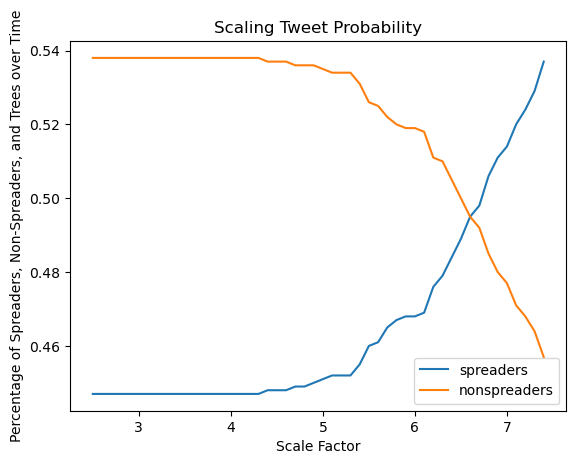

In [26]:
plt.plot(scale_factors_2,p_spreaders2, label="spreaders")
plt.plot(scale_factors_2,p_nonspreaders2, label="nonspreaders")
# plt.plot(scale_factors,trees, label="trees")

plt.xlabel('Title')
plt.ylabel('Percentage of Spreaders, Non-Spreaders, and Trees over Time')
plt.xlabel('Scale Factor')
plt.title('Scaling Tweet Probability')
plt.legend()
plt.show()

# 3D Plot

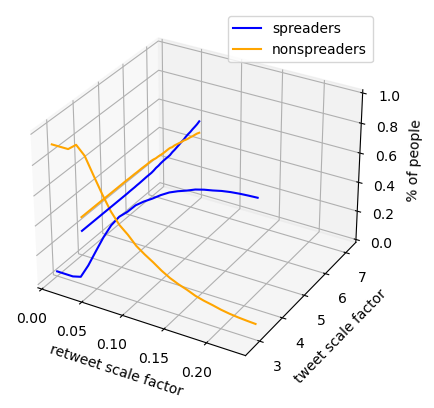

In [27]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.axes.set_xlim3d(left=scale_factors[0], right=scale_factors[-1]) # x is retweet scale factor 
ax.axes.set_ylim3d(bottom=scale_factors_2[0], top=scale_factors_2[-1]) # y is tweet scale factor 
ax.axes.set_zlim3d(bottom=0, top=1) # z is % of people 

ax.set_xlabel('retweet scale factor', rotation=150)
ax.set_ylabel("tweet scale factor")
ax.set_zlabel("% of people",rotation=60)

# PLOT first - changing retweet scale factor, tweet scale factor is 3
ax.plot3D(scale_factors, [3]*len(p_spreaders), p_spreaders, 'blue', label= 'spreaders')
ax.plot3D(scale_factors, [3]*len(p_nonspreaders), p_nonspreaders, 'orange', label= 'nonspreaders')

# second - changing tweet scale factor, retweet scale factor is 0.05
ax.plot3D([.05]*len(p_spreaders2), scale_factors_2, p_spreaders2,  'blue')
ax.plot3D([.05]*len(p_nonspreaders2),scale_factors_2, p_nonspreaders2, 'orange')

ax.legend()


50
50
50


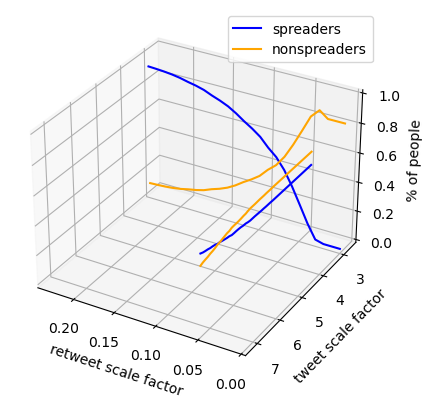

In [36]:
from mpl_toolkits import mplot3d

fig2 = plt.figure()
ax2 = plt.axes(projection ='3d')
ax2.axes.set_xlim3d(left=scale_factors[0], right=scale_factors[-1]) # x is retweet scale factor 
ax2.axes.set_ylim3d(bottom=scale_factors_2[0], top=scale_factors_2[-1]) # y is tweet scale factor 
ax2.axes.set_zlim3d(bottom=0, top=1) # z is % of people 

ax2.set_xlabel('retweet scale factor', rotation=150)
ax2.set_ylabel("tweet scale factor")
ax2.set_zlabel("% of people",rotation=60)

# PLOT first - changing retweet scale factor, tweet scale factor is 3
ax2.plot3D(scale_factors, [3]*len(p_spreaders), p_spreaders, 'blue', label= 'spreaders')
ax2.plot3D(scale_factors, [3]*len(p_nonspreaders), p_nonspreaders, 'orange', label= 'nonspreaders')

# second - changing tweet scale factor, retweet scale factor is 0.05
ax2.plot3D([.05]*len(p_spreaders2), scale_factors_2, p_spreaders2,  'blue')
ax2.plot3D([.05]*len(p_nonspreaders2),scale_factors_2, p_nonspreaders2, 'orange')
ax2.view_init(30, 120)

ax2.legend()

print(len(p_spreaders2))
print(len(p_nonspreaders2))
print(len(scale_factors_2))


In [29]:
print(scale_factors_2)

[2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0000000000000004, 3.1000000000000005, 3.2000000000000006, 3.3000000000000007, 3.400000000000001, 3.500000000000001, 3.600000000000001, 3.700000000000001, 3.800000000000001, 3.9000000000000012, 4.000000000000002, 4.100000000000001, 4.200000000000001, 4.300000000000002, 4.400000000000002, 4.500000000000002, 4.600000000000001, 4.700000000000002, 4.8000000000000025, 4.900000000000002, 5.000000000000002, 5.100000000000002, 5.200000000000003, 5.3000000000000025, 5.400000000000002, 5.500000000000003, 5.600000000000003, 5.700000000000003, 5.8000000000000025, 5.900000000000003, 6.0000000000000036, 6.100000000000003, 6.200000000000003, 6.300000000000003, 6.400000000000004, 6.5000000000000036, 6.600000000000003, 6.700000000000004, 6.800000000000004, 6.900000000000004, 7.0000000000000036, 7.100000000000004, 7.200000000000005, 7.300000000000004, 7.400000000000004]


In [30]:
print(p_spreaders)
print(p_nonspreaders)


[0.012, 0.012, 0.012, 0.027, 0.123, 0.237, 0.349, 0.447, 0.52, 0.569, 0.628, 0.669, 0.704, 0.743, 0.776, 0.8, 0.82, 0.843, 0.858, 0.869, 0.882, 0.891, 0.897, 0.901, 0.904]
[0.867, 0.867, 0.867, 0.91, 0.854, 0.743, 0.635, 0.538, 0.465, 0.417, 0.359, 0.319, 0.284, 0.245, 0.213, 0.189, 0.17, 0.147, 0.132, 0.121, 0.108, 0.099, 0.093, 0.089, 0.086]


In [31]:
print(p_spreaders2)
print(p_nonspreaders2)

[0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.448, 0.448, 0.448, 0.449, 0.449, 0.45, 0.451, 0.452, 0.452, 0.452, 0.455, 0.46, 0.461, 0.465, 0.467, 0.468, 0.468, 0.469, 0.476, 0.479, 0.484, 0.489, 0.495, 0.498, 0.506, 0.511, 0.514, 0.52, 0.524, 0.529, 0.537]
[0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.537, 0.537, 0.537, 0.536, 0.536, 0.536, 0.535, 0.534, 0.534, 0.534, 0.531, 0.526, 0.525, 0.522, 0.52, 0.519, 0.519, 0.518, 0.511, 0.51, 0.505, 0.5, 0.495, 0.492, 0.485, 0.48, 0.477, 0.471, 0.468, 0.464, 0.457]


In [45]:
p_spreaders3 = []
p_nonspreaders3 = []
trees3 = []

#r_u_scaled_static, r_u_sigmoid_scaled_static = scale_retweet_probs(0.07, r_u_init, r_u_sigmoid_init)

#for r_print in r_u_sigmoid_scaled_static.values(): 
 #   print(r_print)
    
for sf1 in scale_factors:
    # regenerate retweet probs
    r_u_scaled, r_u_sigmoid_scaled = scale_retweet_probs(sf1, r_u_init, r_u_sigmoid_init)
    p_spreaders = [] 
    p_nonspreaders = []
    trees = [] 
    
    for sf2 in scale_factors_2: 

        # regenerate tweet probs
        f_u_scaled, f_u_sigmoid_scaled = scale_tweet_probs(sf2,f_u_init_2,f_u_sigmoid_init_2)
        # print('F_U_SIGMOID: ', f_u_sigmoid_scaled)

        # RUN 
        r_0 = 0.5
        f_0 = 0.5
        lists = mff(G1,f_u_sigmoid_scaled,r_u_sigmoid_scaled,f_0,r_0)
        S = lists[0]
        N = lists[1]
        num_S = lists[2]
        num_N = lists[3]
        num_T = lists[4]

    #     print(num_S)

        N_checkpoints = lists[6]
        S_checkpoints = lists[7]

        iterations = lists[5]
        p_s = (num_S[-1])/(numNodes)
        p_ns = (num_N[-1])/(numNodes)
        p_spreaders.append(p_s)
        p_nonspreaders.append(p_ns)
        trees.append(1-(p_s+p_ns))
        
    p_spreaders3.append(p_spreaders)
    p_nonspreaders3.append(p_nonspreaders)
    trees2.append(trees)

In [46]:
print(p_spreaders3)
print(p_nonspreaders3)

[[0.007, 0.007, 0.007, 0.009, 0.011, 0.012, 0.013, 0.018, 0.022, 0.023, 0.024, 0.031, 0.033, 0.037, 0.041, 0.045, 0.049, 0.053, 0.058, 0.063, 0.067, 0.071, 0.075, 0.08, 0.09, 0.099, 0.107, 0.118, 0.124, 0.133, 0.143, 0.147, 0.159, 0.166, 0.175, 0.183, 0.189, 0.203, 0.21, 0.221, 0.231, 0.244, 0.253, 0.269, 0.278, 0.286, 0.298, 0.308, 0.323, 0.338], [0.007, 0.007, 0.007, 0.009, 0.011, 0.012, 0.013, 0.018, 0.022, 0.023, 0.024, 0.031, 0.033, 0.037, 0.041, 0.045, 0.049, 0.053, 0.058, 0.063, 0.067, 0.071, 0.075, 0.08, 0.09, 0.099, 0.107, 0.118, 0.124, 0.133, 0.143, 0.147, 0.159, 0.166, 0.175, 0.183, 0.189, 0.203, 0.21, 0.221, 0.231, 0.244, 0.253, 0.269, 0.278, 0.286, 0.298, 0.308, 0.323, 0.338], [0.007, 0.007, 0.007, 0.009, 0.011, 0.012, 0.013, 0.018, 0.022, 0.023, 0.024, 0.031, 0.033, 0.037, 0.041, 0.045, 0.049, 0.053, 0.058, 0.063, 0.067, 0.071, 0.075, 0.08, 0.09, 0.099, 0.107, 0.118, 0.124, 0.133, 0.143, 0.147, 0.159, 0.166, 0.175, 0.183, 0.189, 0.203, 0.21, 0.221, 0.231, 0.244, 0.253, 0.

X:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y:  [2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0000000000000004, 3.1000000000000005, 3.2000000000000006, 3.3000000000000007, 3.400000000000001, 3.500000000000001, 3.600000000000001, 3.700000000000001, 3.800000000000001, 3.9000000000000012, 4.000000000000002, 4.100000000000001, 4.200000000000001, 4.300000000000002, 4.400000000000002, 4.500000000000002, 4.600000000000001, 4.700000000000002, 4.8000000000000025, 4.900000000000002, 5.000000000000002, 5.100000000000002, 5.200000000000003, 5.3000000000000025, 5.400000000000002, 5.500000000000003, 5.600000000000003, 5.700000000000003, 5.8000000000000025, 5.900000000000003, 6.0000000000000036, 6.100000000000003, 6.200000000000003, 6.300000000000003, 6.400000000000004, 6.500000000

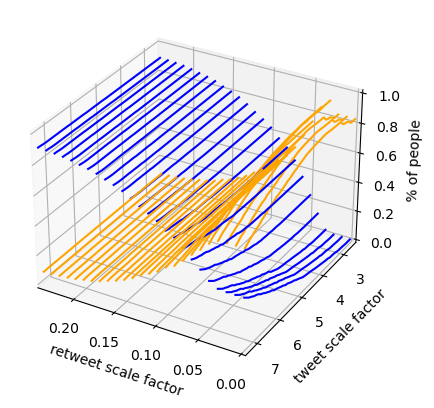

In [47]:
from mpl_toolkits import mplot3d

fig3 = plt.figure()
ax3 = plt.axes(projection ='3d')
ax3.axes.set_xlim3d(left=scale_factors[0], right=scale_factors[-1]) # x is retweet scale factor 
ax3.axes.set_ylim3d(bottom=scale_factors_2[0], top=scale_factors_2[-1]) # y is tweet scale factor 
ax3.axes.set_zlim3d(bottom=0, top=1) # z is % of people 

ax3.set_xlabel('retweet scale factor', rotation=150)
ax3.set_ylabel("tweet scale factor")
ax3.set_zlabel("% of people",rotation=60)

for i in range(len(p_spreaders3)):
    # i - retweet probability 
    # j - tweet probability 
    # grab this retweet prob 
    
    r_prob_scale = scale_factors[i] 
    
    print("X: ", [r_prob_scale]*len(p_spreaders3[i]))
    print("Y: ", scale_factors_2)
    print("Z: ", p_spreaders3[i])
    
    ax3.plot3D([r_prob_scale]*len(p_spreaders3[i]), scale_factors_2,  p_spreaders3[i], 'blue')
    ax3.plot3D([r_prob_scale]*len(p_spreaders3[i]), scale_factors_2,  p_nonspreaders3[i], 'orange')

        
    
    
# PLOT first - changing retweet scale factor, tweet scale factor is 3
#ax3.plot3D(scale_factors, scale_factors_2, p_spreaders3, 'blue', label= 'spreaders')
#ax3.plot3D(scale_factors, scale_factors_2, p_nonspreaders3, 'orange', label= 'nonspreaders')


ax3.view_init(30, 120)

#ax3.legend()



X:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y:  [2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0000000000000004, 3.1000000000000005, 3.2000000000000006, 3.3000000000000007, 3.400000000000001, 3.500000000000001, 3.600000000000001, 3.700000000000001, 3.800000000000001, 3.9000000000000012, 4.000000000000002, 4.100000000000001, 4.200000000000001, 4.300000000000002, 4.400000000000002, 4.500000000000002, 4.600000000000001, 4.700000000000002, 4.8000000000000025, 4.900000000000002, 5.000000000000002, 5.100000000000002, 5.200000000000003, 5.3000000000000025, 5.400000000000002, 5.500000000000003, 5.600000000000003, 5.700000000000003, 5.8000000000000025, 5.900000000000003, 6.0000000000000036, 6.100000000000003, 6.200000000000003, 6.300000000000003, 6.400000000000004, 6.5000000000000036, 6.600000000000003, 6.700000000000004, 6.800000000000004, 6.900000000000004, 7.0000000000000036, 7.100000000000004, 7

/var/folders/3b/psvsh4hj5lzcs5w1csnk_f740000gn/T/ipykernel_18299/3424234052.py:27: MatplotlibDeprecationWarning: Additional positional arguments to plot_surface() are deprecated since 3.4 and support for them will be removed two minor releases later.
  surf1 = ax3.plot_surface(X, Y,  Z1, 'blue')


ValueError: Argument Z must be 2-dimensional.

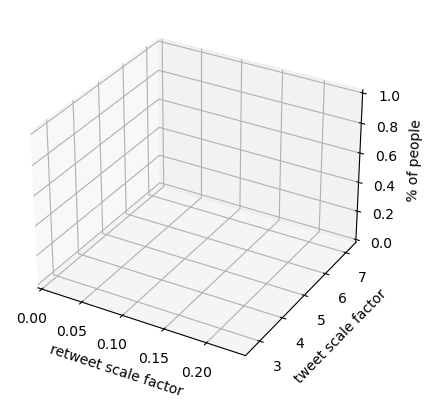

In [51]:
from mpl_toolkits import mplot3d

fig3 = plt.figure()
ax3 = plt.axes(projection ='3d')
ax3.axes.set_xlim3d(left=scale_factors[0], right=scale_factors[-1]) # x is retweet scale factor 
ax3.axes.set_ylim3d(bottom=scale_factors_2[0], top=scale_factors_2[-1]) # y is tweet scale factor 
ax3.axes.set_zlim3d(bottom=0, top=1) # z is % of people 

ax3.set_xlabel('retweet scale factor', rotation=150)
ax3.set_ylabel("tweet scale factor")
ax3.set_zlabel("% of people",rotation=60)

for i in range(len(p_spreaders3)):
    # i - retweet probability 
    # j - tweet probability 
    # grab this retweet prob 
    
    r_prob_scale = scale_factors[i] 
    
    print("X: ", [r_prob_scale]*len(p_spreaders3[i]))
    print("Y: ", scale_factors_2)
    print("Z: ", p_spreaders3[i])
    X = numpy.asarray([r_prob_scale]*len(p_spreaders3[i]))
    Y = numpy.asarray(scale_factors_2)
    Z1 = numpy.asarray(p_spreaders3[i])
    Z2 = numpy.asarray(p_nonspreaders3[i])
    surf1 = ax3.plot_surface(X, Y,  Z1, 'blue')
    surf2 = ax3.plot_surface(X, Y,  Z2, 'blue')
    
    #ax3.plot3D([r_prob_scale]*len(p_spreaders3[i]), scale_factors_2,  p_spreaders3[i], 'blue')
    #ax3.plot3D([r_prob_scale]*len(p_spreaders3[i]), scale_factors_2,  p_nonspreaders3[i], 'orange')

        
plt.show()
    
# PLOT first - changing retweet scale factor, tweet scale factor is 3
#ax3.plot3D(scale_factors, scale_factors_2, p_spreaders3, 'blue', label= 'spreaders')
#ax3.plot3D(scale_factors, scale_factors_2, p_nonspreaders3, 'orange', label= 'nonspreaders')


ax3.view_init(30, 120)

#ax3.legend()



In [70]:
tweet_scale_factors_test = list(np.arange(2.5, 7.5, 0.2))
print(len(tweet_scale_factors_test))

25


In [74]:
p_spreaders4 = []
p_nonspreaders4 = []
trees4 = []

#r_u_scaled_static, r_u_sigmoid_scaled_static = scale_retweet_probs(0.07, r_u_init, r_u_sigmoid_init)

#for r_print in r_u_sigmoid_scaled_static.values(): 
 #   print(r_print)
    
for sf1 in scale_factors:
    # regenerate retweet probs
    r_u_scaled, r_u_sigmoid_scaled = scale_retweet_probs(sf1, r_u_init, r_u_sigmoid_init)
    p_spreaders = [] 
    p_nonspreaders = []
    trees = [] 
    
    for sf2 in tweet_scale_factors_test: 

        # regenerate tweet probs
        f_u_scaled, f_u_sigmoid_scaled = scale_tweet_probs(sf2,f_u_init_2,f_u_sigmoid_init_2)
        # print('F_U_SIGMOID: ', f_u_sigmoid_scaled)

        # RUN 
        r_0 = 0.5
        f_0 = 0.5
        lists = mff(G1,f_u_sigmoid_scaled,r_u_sigmoid_scaled,f_0,r_0)
        S = lists[0]
        N = lists[1]
        num_S = lists[2]
        num_N = lists[3]
        num_T = lists[4]

    #     print(num_S)

        N_checkpoints = lists[6]
        S_checkpoints = lists[7]

        iterations = lists[5]
        p_s = (num_S[-1])/(numNodes)
        p_ns = (num_N[-1])/(numNodes)
        p_spreaders.append(p_s)
        p_nonspreaders.append(p_ns)
        trees.append(1-(p_s+p_ns))
        
    p_spreaders4.append(p_spreaders)
    p_nonspreaders4.append(p_nonspreaders)
    trees4.append(trees)

(25, 25)
(25, 25)
(25, 25)


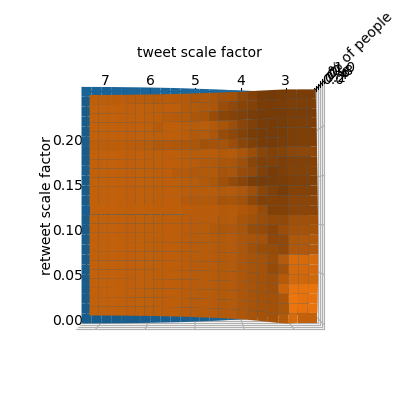

In [215]:
fig4 = plt.figure()
ax4 = plt.axes(projection ='3d')
ax4.axes.set_xlim3d(left=scale_factors[0], right=scale_factors[-1]) # x is retweet scale factor 
ax4.axes.set_ylim3d(bottom=tweet_scale_factors_test[0], top=tweet_scale_factors_test[-1]) # y is tweet scale factor 
ax4.axes.set_zlim3d(bottom=0, top=1) # z is % of people 

ax4.set_xlabel('retweet scale factor', rotation=150)
ax4.set_ylabel("tweet scale factor")
ax4.set_zlabel("% of people",rotation=60)

X = numpy.asarray(scale_factors)
Y = numpy.asarray(tweet_scale_factors_test)
X, Y = np.meshgrid(X,Y)

Z1 = numpy.asarray(p_spreaders4)
Z2 = numpy.asarray(p_nonspreaders4)

#print(X)
#print(Z1)
print(X.shape)
print(Y.shape)
print(Z1.shape)

surf = ax4.plot_surface(X, Y,  Z1)
surf2 = ax4.plot_surface(X, Y,  Z2)

# 15, 150
ax4.view_init(90, 180)

plt.show()

# new visualization

In [162]:
# Graph 
numNodes_small = 30
p_small = 0.15
averageDeg_small = numNodes_small*p_small
totalDegSum_small= total_degree_sum(p_small,numNodes_small)

degree_small = createRandomDist(numNodes_small, averageDeg_small,totalDegSum_small)
in_degrees_small = degree_small[0]
#print(type(in_degrees))
out_degrees_small = degree_small[1]
#print("\n IN DEGREES \n")
#print((in_degrees))
#print("\n OUT DEGREES \n")
#print((out_degrees))

In [165]:
#G1 = gnp_random_graph(n=1000, p=0.15, seed=numpy.random, directed=True)
G_small = nx.directed_configuration_model(in_degree_sequence = in_degrees_small,out_degree_sequence = out_degrees_small)
G_small.remove_edges_from(nx.selfloop_edges(G_small))


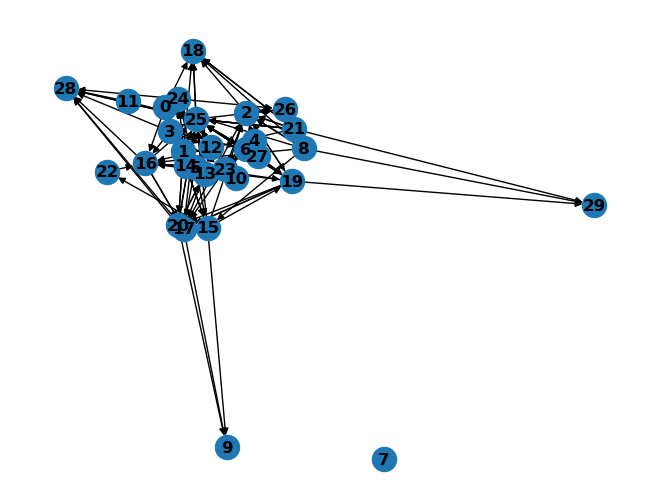

In [166]:
nx.draw(G_small,with_labels=True,font_weight='bold')
plt.show()

In [167]:
# Compute all user activities and topic significance 
UA_small = {}
for node in G_small.nodes: 
    UA_small[node] = UserActivity(G1,node)
    
TS_small = 1

In [168]:
#### Compute tweet probs 
f_u_init_small = {}
f_u_sigmoid_init_small = {}
scale_factor_small = 3
for node in G_small.nodes: 
    # compute f_u 
    f =  compute_tweet_prob(G_small,TS_small,UA_small[node],scale_factor_small)
    f_u_init_small[node]=f
    f_u_sigmoid_init_small[node] = sigmoid(f)

print(sorted(f_u_sigmoid_init_small.values()))

[0.14888503362331806, 0.149984601143067, 0.15011342695836238, 0.15071369110432564, 0.15123843754337551, 0.15269867565723128, 0.15317479575579207, 0.15321212198123235, 0.15349126698701054, 0.1591822523969213, 0.16658988867506053, 0.17047476850944498, 0.1707824106213094, 0.17140688314436536, 0.17337377532566678, 0.17337782435175564, 0.17486342960856138, 0.1795891110436214, 0.18894148658654908, 0.19042867605508773, 0.19272394217255173, 0.19441597730420357, 0.2060478191036732, 0.23004793247839328, 0.24508751445744048, 0.29466993501702143, 0.3061657754538052, 0.4032746939013405, 0.4253040546682494, 0.5149940319407533]


In [169]:
#### Computing retweet prob
r_u_init_small = {}
r_u_sigmoid_init_small = {}
scale_factor_small = 0.05
for node in G_small.nodes: 
    # loop through followers
    for follower in G_small.predecessors(node):
        r = compute_retweet_prob(G_small,node,follower,scale_factor_small,TS_small,UA_small[node])
        r_u_init_small[(node,follower)] = r
        r_u_sigmoid_init_small[(node,follower)] = sigmoid(r)

print(sorted(r_u_sigmoid_init_small.values()))

[0.002499994791679727, 0.002499994791679727, 0.002499994791679727, 0.002505811772673061, 0.0025111411161986563, 0.0025111411161986563, 0.0025111411161986563, 0.0025203182902076016, 0.0025204952486106436, 0.002521818701700429, 0.0026040333235279878, 0.002616396389509168, 0.002616415715804399, 0.002690915916935488, 0.0027172273740934116, 0.0027172273740934116, 0.0027172273740934116, 0.0027172273740934116, 0.0029637859280349232, 0.0029637859280349232, 0.0029637859280349232, 0.003269937820027824, 0.003269937820027824, 0.003908080407892145, 0.003908080407892145, 0.007505676068149558, 0.007505676068149558, 0.007505676068149558, 0.007511005144765326, 0.007511005144765326, 0.007520358808007055, 0.007521682194646662, 0.007521682194646662, 0.007521682194646662, 0.007583915465714464, 0.007583915465714464, 0.007583915465714464, 0.007603892654153954, 0.007603892654153954, 0.007606870742231209, 0.007606870742231209, 0.007616255088377821, 0.007645953191208088, 0.007697912466911427, 0.0076979124669114

In [170]:
# create new small graph 
# RUN 
r_0_small = 0.5
f_0_small = 0.5
lists_small = mff(G1,f_u_sigmoid_init,r_u_sigmoid_scaled,f_0,r_0)
S_small = lists[0]
N_small = lists[1]
num_S_small = lists[2]
num_N_small = lists[3]
num_T_small = lists[4]
    

N_checkpoints_small = lists[6]
S_checkpoints_small = lists[7]

iterations_small = lists[5]



In [190]:
color_map1_small = []
color_map2_small = []
color_map3_small = []
color_map4_small = []
color_map5_small = []

# green - trees
# yellow - spreaders
# red - non-spreaders 


for node in G_small.nodes: 
    # FIRST CHECKPOINT
    if node in N_checkpoints_small[0]:  # non-spreader
        color_map1_small.append('red') 
    elif node in S_checkpoints[0]:   # spreader
        color_map1_small.append('yellow')
    else: 
        color_map1_small.append('green')   # unreached tree
         
    # SECOND CHECKPOINT
    if node in N_checkpoints_small[1]:  # non-spreader
        color_map2_small.append('red') 
    elif node in S_checkpoints[1]:   # spreader
        color_map2_small.append('yellow')
    else: 
        color_map2_small.append('green')   # unreached tree
        
        
    # THIRD CHECKPOINT
    if node in N_checkpoints_small[2]:  # non-spreader
        color_map3_small.append('red') 
    elif node in S_checkpoints[2]:   # spreader
        color_map3_small.append('yellow')
    else: 
        color_map3_small.append('green')   # unreached tree
        
        
    # FOURTH CHECKPOINT
    if node in N_checkpoints_small[3]:  # non-spreader
        color_map4_small.append('red') 
    elif node in S_checkpoints[3]:   # spreader
        color_map4_small.append('yellow')
    else: 
        color_map4_small.append('green')   # unreached tree
        
    # FIFTH CHECKPOINT
    if node in N_checkpoints_small[4]:  # non-spreader
        color_map5_small.append('red') 
    elif node in S_checkpoints[4]:   # spreader
        color_map5_small.append('yellow')
    else: 
        color_map5_small.append('green')   # unreached tree
        
        
        


In [191]:
my_pos = nx.spring_layout(G_small, seed = 50)


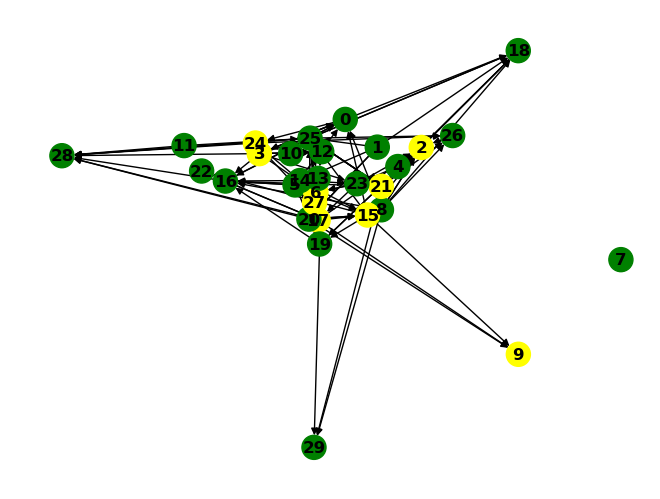

In [192]:
nx.draw(G_small,pos = my_pos,with_labels=True,node_color=color_map1_small, font_weight='bold')
plt.show()

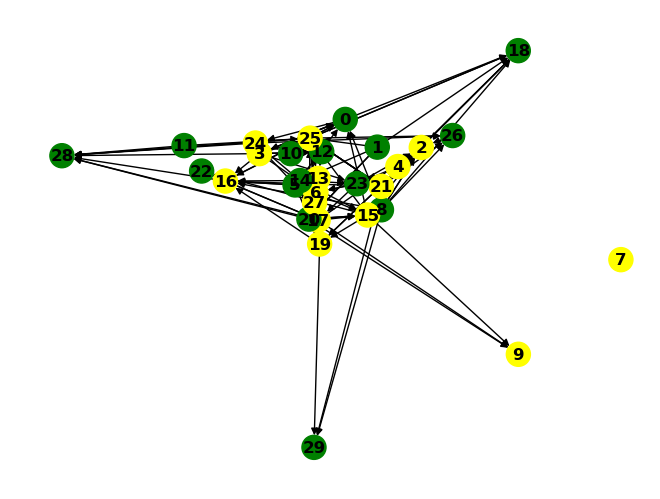

In [193]:
nx.draw(G_small,pos = my_pos,with_labels=True,node_color=color_map2_small, font_weight='bold')
plt.show()

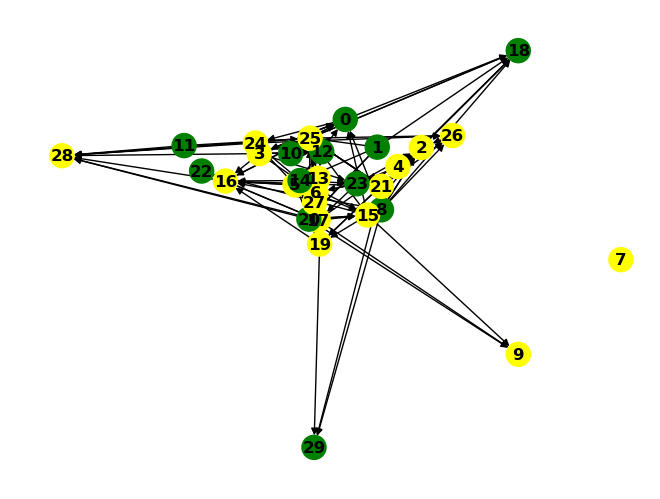

In [194]:
nx.draw(G_small,pos = my_pos,with_labels=True,node_color=color_map3_small, font_weight='bold')
plt.show()

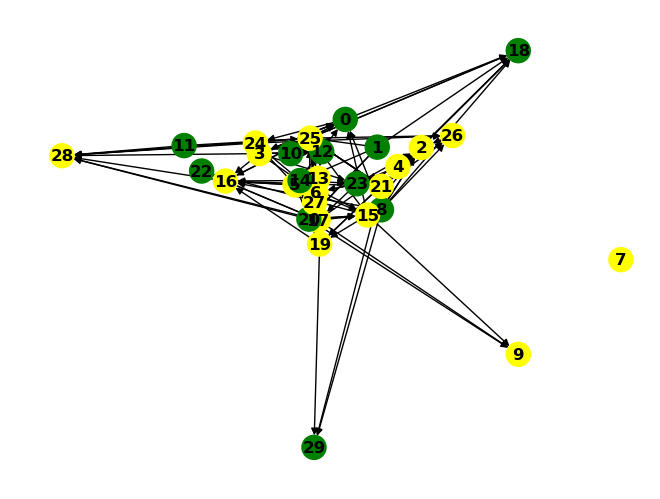

In [195]:
nx.draw(G_small,pos = my_pos,with_labels=True,node_color=color_map4_small, font_weight='bold')
plt.show()

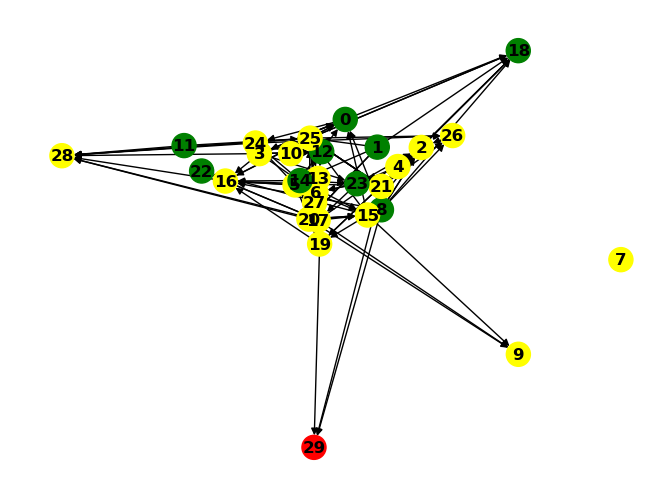

In [196]:
nx.draw(G_small,pos = my_pos,with_labels=True,node_color=color_map5_small, font_weight='bold')
plt.show()